## Goal:
## This notebook will work on defining states through
- TypedDict
- Dataclasses
- Pydantic

**Best Practice**
- Use `Pydantic` if you want stronger validation and to leverage LangGraph's reducer-based accumulation semantics, but expect to do some serialization handling with LangChain's message types. E.g. `messages: Annotated[List[AnyMessage], add] = Field(default_factory=list)`

- Use `Dataclass` if you want simplicity and avoid serialization quirks and validation overhead, with direct Python list appends for messages.E.g. `messages: List[AnyMessage] = field(default_factory=list)`

In [1]:
from dotenv import load_dotenv

from typing import TypedDict, Annotated, Any
from dataclasses import dataclass
from pydantic import BaseModel, ValidationError, Field
from dataclasses import dataclass, field

from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from IPython.display import display, Image

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4o")

## TypedDict

In [ ]:
class ChatState(TypedDict):
    messages: Annotated[list[AIMessage | HumanMessage], add_messages]

In [ ]:
def llm_node(state: ChatState):
    response = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}

In [ ]:
graph = StateGraph(ChatState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
app = graph.compile()

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
state: ChatState = {"messages": []}

In [ ]:
while True:
    user_input = input("You: ")
    if user_input == "Exit":
        break
    state["messages"].append(HumanMessage(content=user_input))
    state = app.invoke(state)
    print("Bot:", state["messages"][-1].content)    

## Pydantic
- This looks correct on the surface, but the `AttributeError` arises because `AIMessage` and `HumanMessage` are not `Pydantic models` or plain `dicts` —Pydantic tries to validate them and calls .get internally, which these classes do not implement.

In [ ]:
class ChatState(BaseModel):
    messages: list[dict[str, Any]] = Field(default_factory=list)

In [ ]:
def serialize_message(msg):
    if isinstance(msg, HumanMessage):
        return {"type": "human", "content": msg.content}
    elif isinstance(msg, AIMessage):
        return {"type": "ai", "content": msg.content}
    else:
        raise ValueError("Unknown message type")

def deserialize_message(msg_dict):
    if msg_dict["type"] == "human":
        return HumanMessage(content=msg_dict["content"])
    elif msg_dict["type"] == "ai":
        return AIMessage(content=msg_dict["content"])
    else:
        raise ValueError("Unknown message dict type")

In [ ]:
def llm_node(state: ChatState):
    history = [deserialize_message(msg) for msg in state.messages]
    response = llm.invoke(history)
    return ChatState(messages=state.messages + [serialize_message(response)])

In [ ]:
graph = StateGraph(ChatState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
app = graph.compile()

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
state = ChatState(messages=[])

In [ ]:
while True:
    user_input = input("You: ").strip()
    if user_input.lower() == "exit":
        break
        
    # Add user's message as dict to history
    state.messages.append(serialize_message(HumanMessage(content=user_input)))
    
    # Process and update state using the graph
    raw_state = app.invoke(state)   # This returns dict
    
    # Re-create model from dict
    state = ChatState(**raw_state)  # Now state is a model with .messages
    
    # Output new AI response (deserialize first)
    print("Bot:", deserialize_message(state.messages[-1]).content)

## Dataclass

In [4]:
@dataclass
class ChatState:
    messages: list[AIMessage | HumanMessage] = field(default_factory=list)

In [5]:
def llm_node(state: ChatState):
    response = llm.invoke(state.messages)
    #return {"messages": state.messages + [response]}
    return ChatState(messages=state.messages + [response])

In [6]:
graph = StateGraph(ChatState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
app = graph.compile()

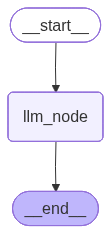

In [7]:
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
state = ChatState(messages=[])

In [12]:
while True:
    user_input = input("You: ").strip()
    if user_input.lower() == "exit":
        break
    state.messages.append(HumanMessage(content=user_input))
    raw_state = app.invoke(state) 
    state = ChatState(**raw_state)
    print("Bot:", state.messages[-1].content) 

You:  Hi


Bot: Hello! How can I assist you today?


You:  Exit


## Useful Tips